In [34]:
# Module Load

import sys
import nibabel as nib
import numpy as np
from nilearn import plotting as plot
from nilearn.image.image import mean_img
import pandas as pd
from nilearn.image import load_img, new_img_like
from nilearn import image as img
from nilearn.plotting import plot_design_matrix
import os
from nilearn.glm.first_level import FirstLevelModel
from nilearn.plotting import plot_stat_map
from nilearn.glm import threshold_stats_img
from nilearn.reporting import get_clusters_table
from nilearn.plotting import plot_contrast_matrix
from nilearn.masking import intersect_masks
from nilearn.glm.contrasts import compute_fixed_effects
from nilearn.reporting import make_glm_report
from nilearn.glm.second_level import SecondLevelModel
from nilearn.image import math_img
from nilearn.datasets import fetch_neurovault_ids
from nilearn import datasets
from nilearn.image import smooth_img
from scipy.stats import ttest_ind
from scipy.ndimage import binary_dilation, label
from nilearn.image import get_data
from nilearn.plotting import plot_roi
from nilearn.datasets import load_mni152_template
from nilearn.image import resample_to_img
from scipy.ndimage import label

from nilearn.maskers import NiftiSpheresMasker




In [35]:
project_dir = "/home/gagpat01/Documents/GutBrain"
data_dir = f"{project_dir}/data5"
derivatives_dir = f"{project_dir}/derivatives4/fmriprep"
results_dir = f"{project_dir}/BIDS_results"



# Define the path to the image
image_path = f"{results_dir}/27.4.22_24studies_ALE.nii.gz"

# Load the image
try:
    ale_image = load_img(image_path)
    print("Image loaded successfully.")
except Exception as e:
    print(f"Error loading image: {e}")

# Inspect the range of values in the t-stat map
data = ale_image.get_fdata()
min_val, max_val = data.min(), data.max()
print(f"Range of t-stat values: {min_val} to {max_val}")



Image loaded successfully.
Range of t-stat values: 0.0 to 0.02956264466047287


In [36]:
# Compute clusters from ale_image
try:
    clusters_table = get_clusters_table(ale_image, stat_threshold=0.01105, cluster_threshold=25)
    print("Clusters computed successfully.")
    print(clusters_table)
except Exception as e:
    print(f"Error computing clusters: {e}")

Clusters computed successfully.
   Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0           1  10.0  14.0  -4.0   0.029563               1008
1           2  46.0  42.0  12.0   0.024792               1072
2          2a  48.0  38.0  22.0   0.016517                   
3           3  -2.0  40.0 -12.0   0.024635               4584
4          3a  -8.0  48.0  -6.0   0.024125                   
5          3b   6.0  46.0   0.0   0.019539                   
6          3c  -4.0  28.0 -12.0   0.018977                   
7           4  34.0  22.0   0.0   0.021324                784
8           5  50.0  10.0  20.0   0.019819                968
9           6  56.0 -44.0 -16.0   0.019029                416
10          7  -6.0 -52.0  14.0   0.017625                392
11          8 -10.0   8.0  -4.0   0.016705               1048
12          9   0.0  26.0  44.0   0.015254                272
13         10 -34.0  22.0  -4.0   0.013510                472
14        10a -32.0  12.0  -6.0   0.01

In [37]:
# Ensure the 'Cluster ID' column is of type string
clusters_table['Cluster ID'] = clusters_table['Cluster ID'].astype(str)

# Define a mapping of old Cluster IDs to new labels
cluster_label_mapping = {
    "1": "VS R",
    "2": "dlPFC R 1",
    "3": "vmPFC L 1",
    "4": "AI R",
    "5": "IFG R",
    "2a": "dlPFC R 2",
    "3a": "vmPFC L 2",
    "3b": "Pregenual ACC R",
    "3c": "Subgenual ACC L",
    "8": "VS L"
}

# Apply the mapping to the 'Cluster ID' column
clusters_table['Cluster Label'] = clusters_table['Cluster ID'].map(cluster_label_mapping)

# Remove rows where 'Cluster Label' is NaN
clusters_table = clusters_table.dropna(subset=['Cluster Label'])

# Display the updated DataFrame
print(clusters_table)

   Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)    Cluster Label
0           1  10.0  14.0  -4.0   0.029563               1008             VS R
1           2  46.0  42.0  12.0   0.024792               1072        dlPFC R 1
2          2a  48.0  38.0  22.0   0.016517                           dlPFC R 2
3           3  -2.0  40.0 -12.0   0.024635               4584        vmPFC L 1
4          3a  -8.0  48.0  -6.0   0.024125                           vmPFC L 2
5          3b   6.0  46.0   0.0   0.019539                     Pregenual ACC R
6          3c  -4.0  28.0 -12.0   0.018977                     Subgenual ACC L
7           4  34.0  22.0   0.0   0.021324                784             AI R
8           5  50.0  10.0  20.0   0.019819                968            IFG R
11          8 -10.0   8.0  -4.0   0.016705               1048             VS L


In [38]:

# Create a binary mask for the combined clusters
global_valuation_ROI = math_img("img > 0.01105", img=ale_image)




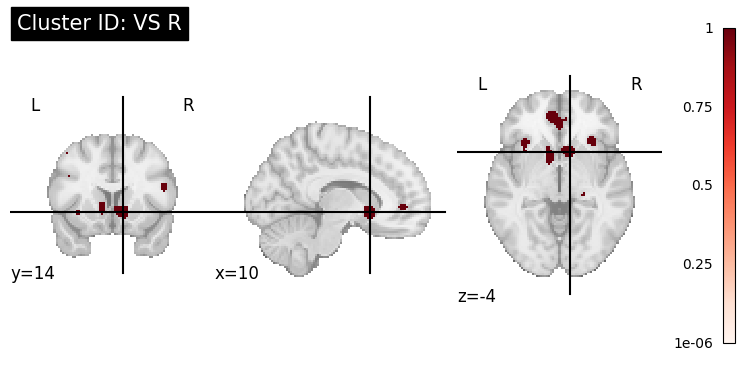

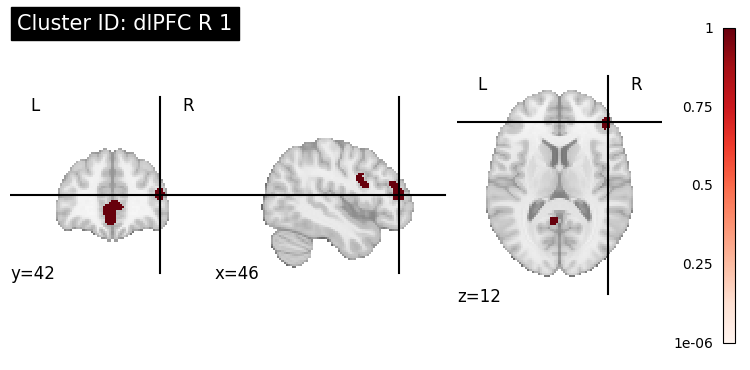

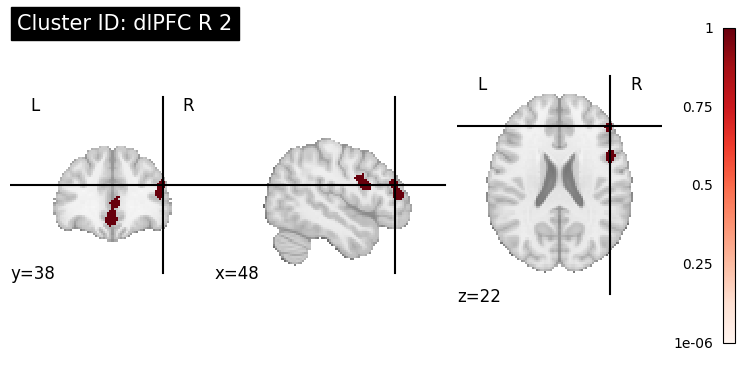

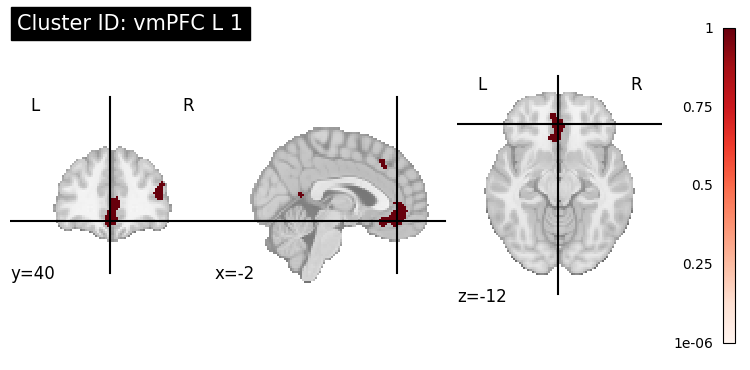

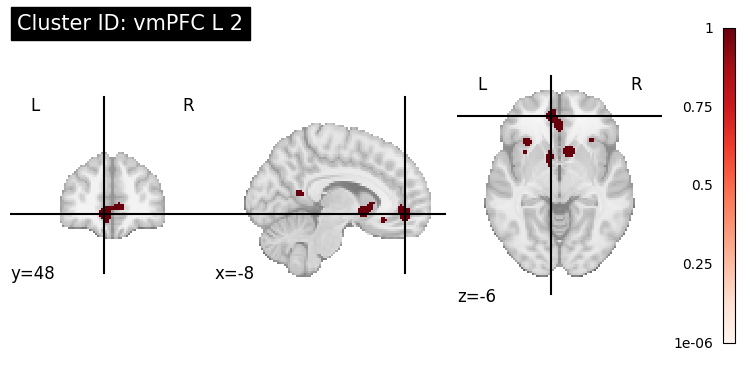

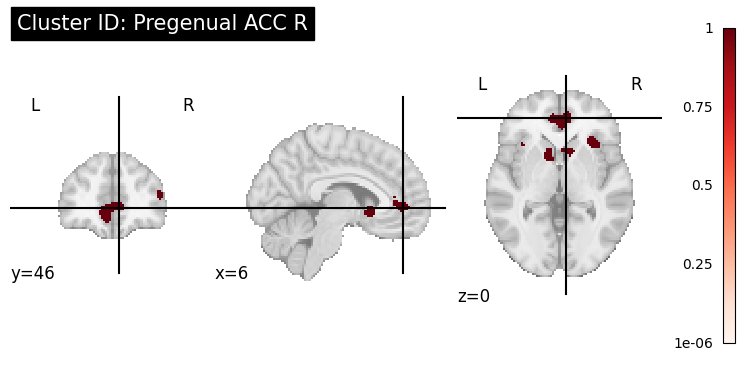

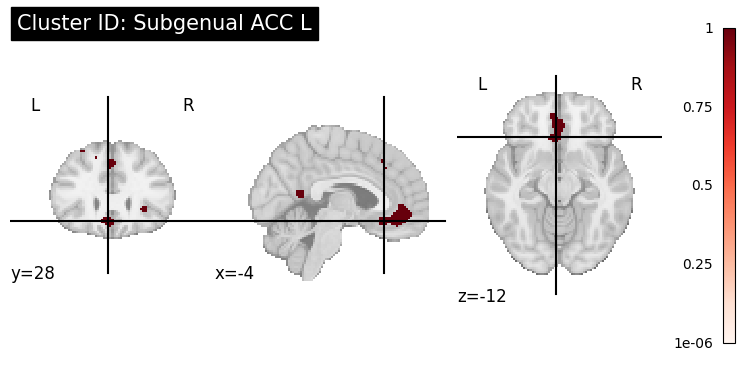

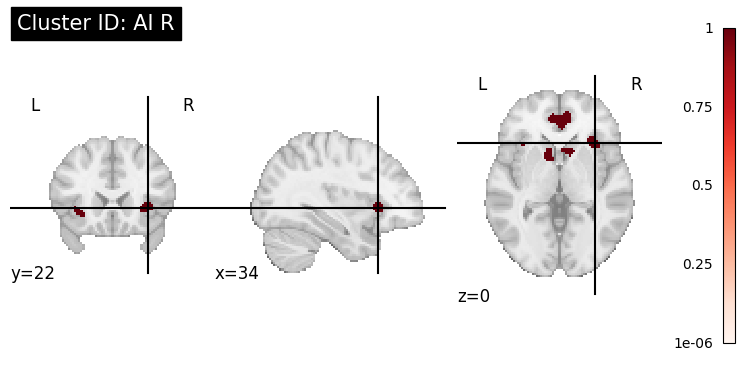

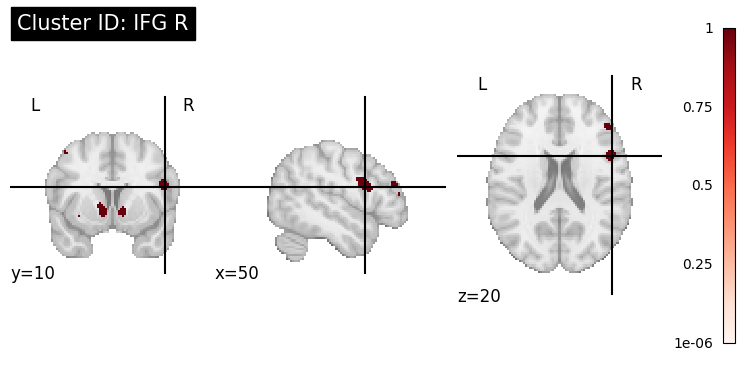

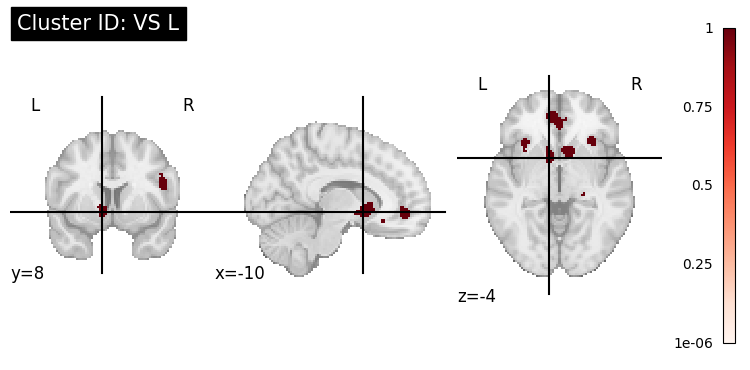

In [39]:

for _, row in clusters_table.iterrows():
    cut_coords = (row['X'], row['Y'], row['Z'])
    plot_stat_map(global_valuation_ROI, title=f"Cluster ID: {row['Cluster Label']}", cut_coords=cut_coords, colorbar=True, cmap='Reds')

/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/nilearn/plotting/displays/_slicers.py:956: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = self.cut_coords[
/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/nilearn/plotting/displays/_slicers.py:313: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)
/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/numpy/ma/core.py:2892: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/nilearn/plotting/displays/_slicers.py:1055: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent 

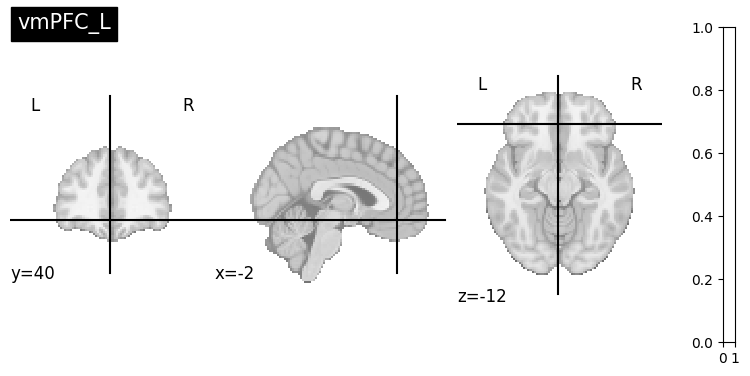

In [40]:
# Extract the coordinates of Cluster ID 3
cluster_3_coords = clusters_table[clusters_table['Cluster ID'] == '3'][['X', 'Y', 'Z']].iloc[0]

# Create a binary mask for the cluster
cluster_3_mask = math_img(
    f"(img == 1) & (img == {data[int(cluster_3_coords['X']), int(cluster_3_coords['Y']), int(cluster_3_coords['Z'])]})",
    img=global_valuation_ROI
)

# Assign the mask to vmPFC_L
vmPFC_L = cluster_3_mask

# Plot the vmPFC_L mask
plot_roi(vmPFC_L, title="vmPFC_L", cut_coords=cluster_3_coords, colorbar=True, cmap='Reds')

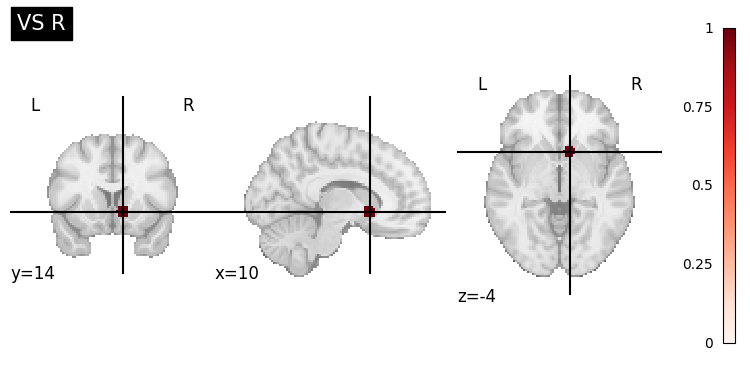

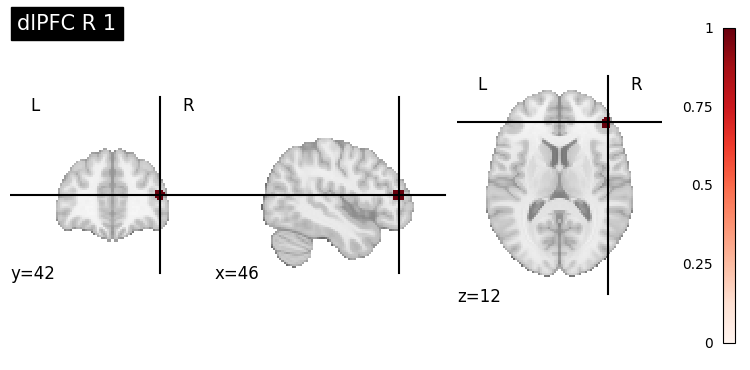

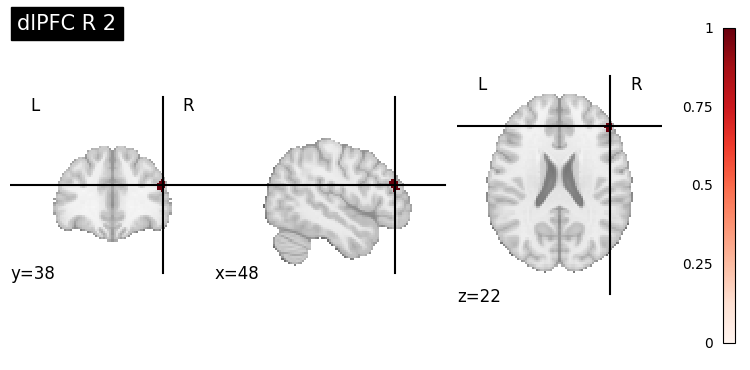

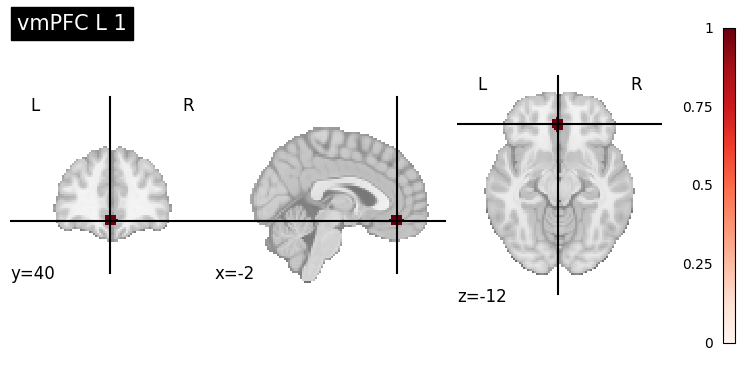

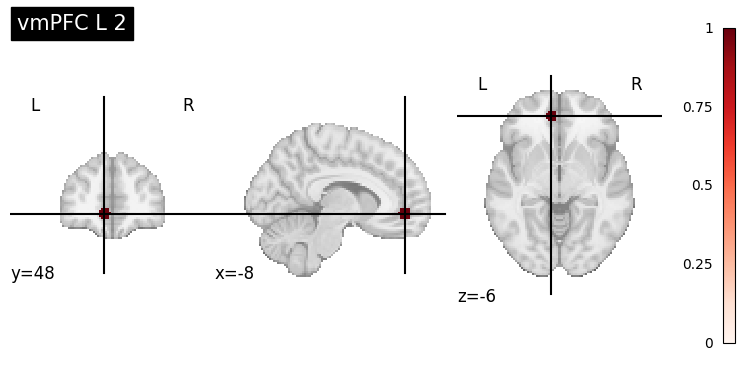

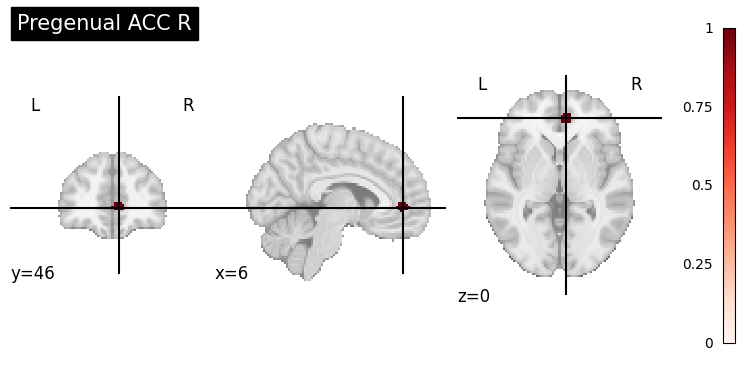

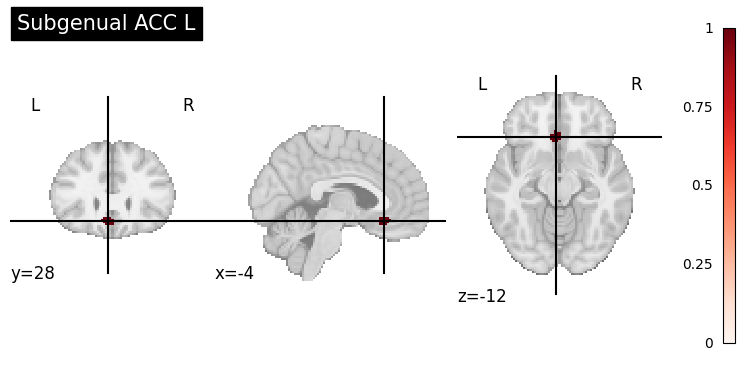

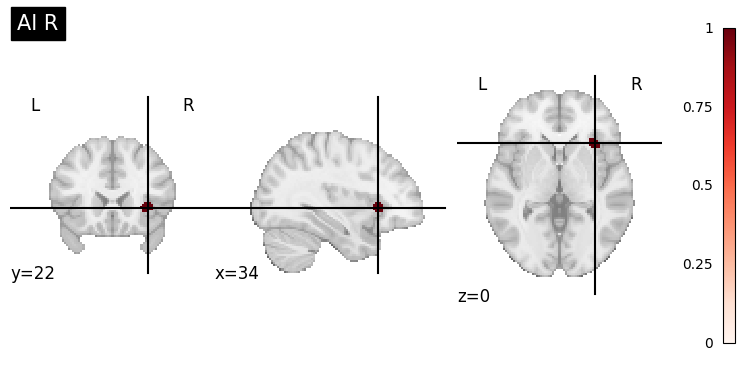

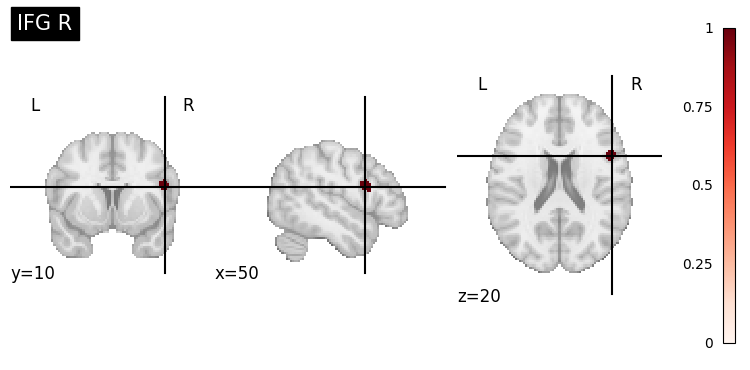

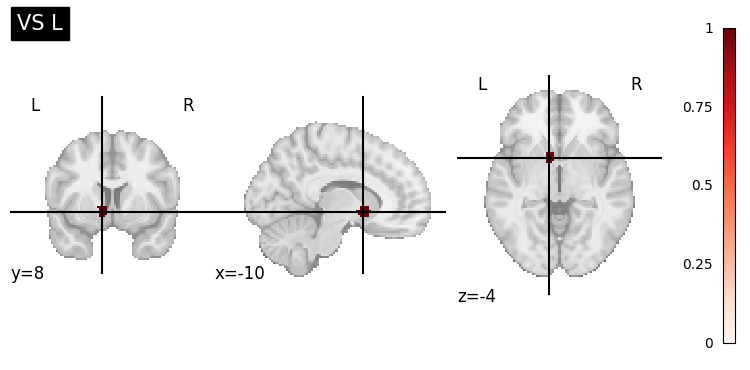

In [41]:
# Radius for spherical masks
sphere_radius = 6  # mm

# Loop through each cluster
for _, row in clusters_table.iterrows():
    cluster_label = row["Cluster Label"]
    if not isinstance(cluster_label, str) or not cluster_label.strip():
        print(f"Skipping unnamed cluster at {row[['X', 'Y', 'Z']].tolist()}")
        continue  # Skip if no label

    coord = [(row["X"], row["Y"], row["Z"])]

    # Create a spherical ROI at the coordinate, constrained to the ALE thresholded mask
    masker = NiftiSpheresMasker(seeds=coord, radius=sphere_radius, mask_img=global_valuation_ROI)
    masker.fit(global_valuation_ROI)

    # Project sphere back into 3D image
    sphere_img = masker.inverse_transform(np.ones((1, 1)))

        # Squeeze sphere_img to 3D
    sphere_bin_3d = nib.Nifti1Image(
        np.squeeze(sphere_img.get_fdata() > 0),
        affine=sphere_img.affine,
        header=sphere_img.header
    )

    # Intersect with global_valuation_ROI
    final_mask = math_img("img1 * img2", img1=sphere_bin_3d, img2=global_valuation_ROI)


    # Plot
    plot.plot_stat_map(
        final_mask,
        title=cluster_label,
        display_mode='ortho',
        cut_coords=[row["X"], row["Y"], row["Z"]],
        threshold=0,
        cmap='Reds',
        draw_cross=True
    )
    plot.show()

Found 23 connected clusters.


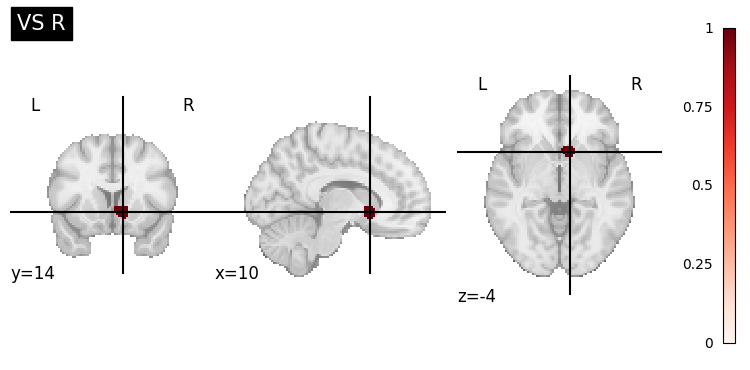

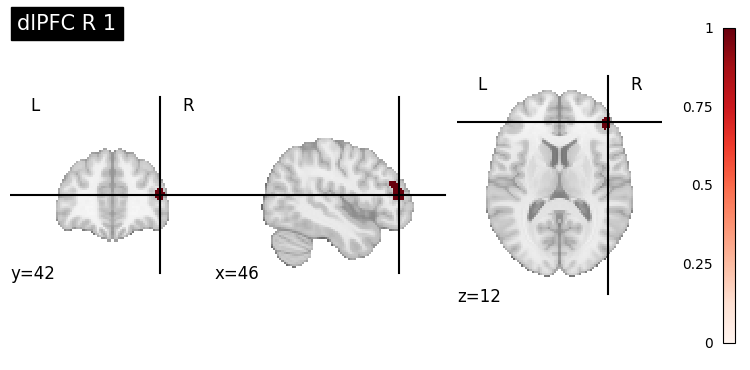

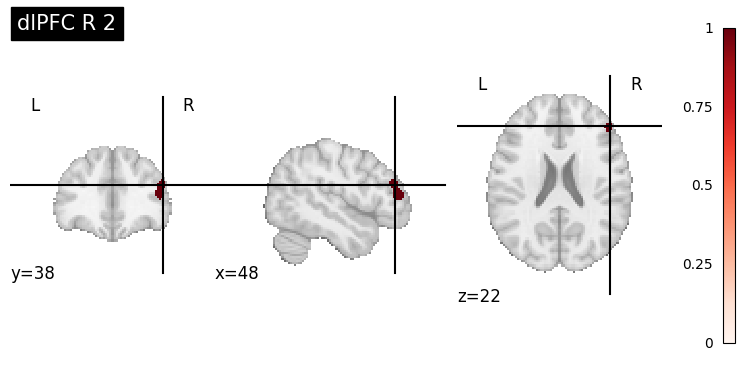

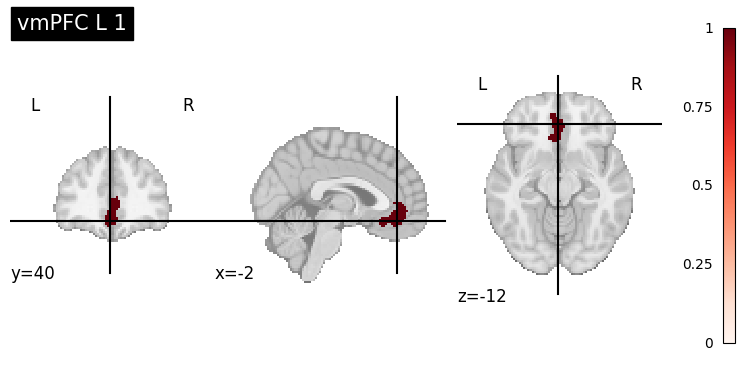

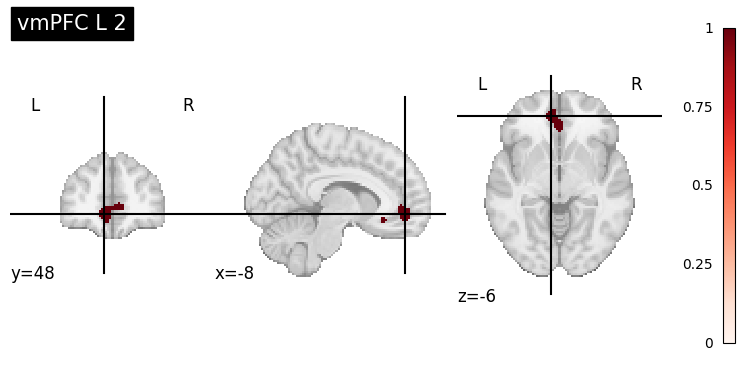

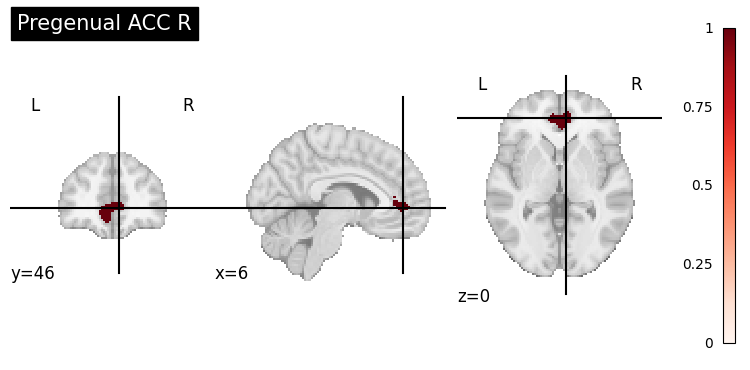

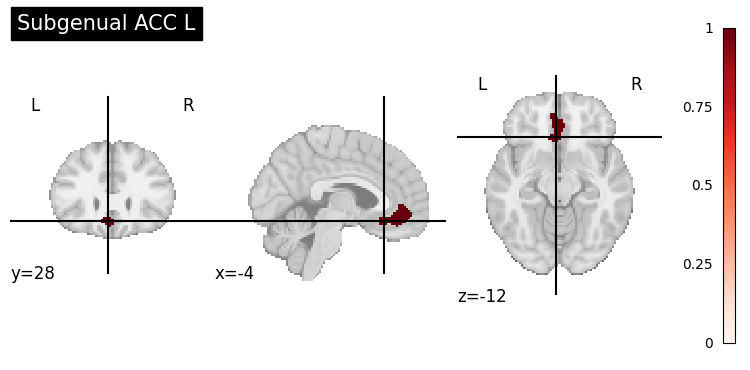

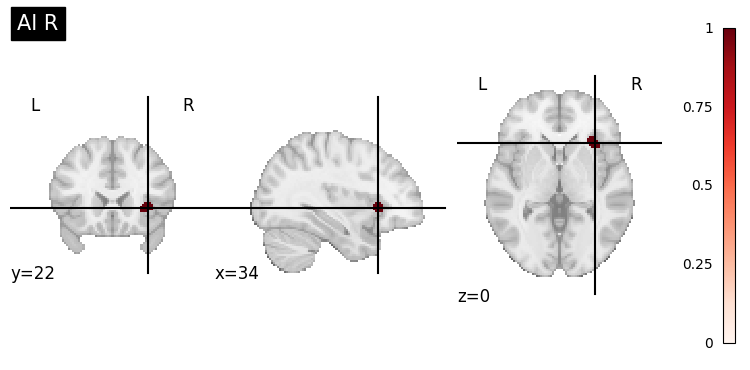

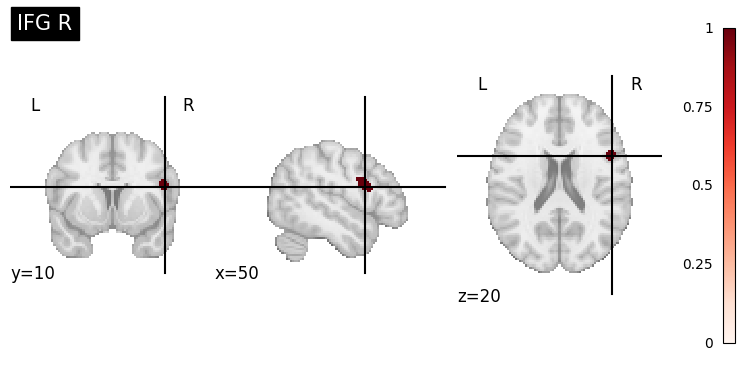

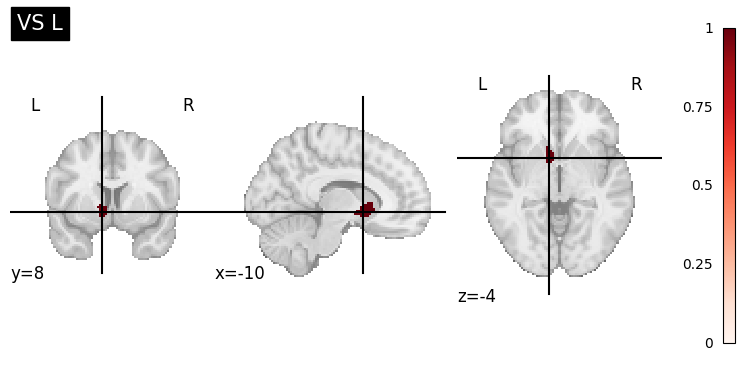

In [42]:


# Step 1: Load your thresholded ALE image
# (or reuse global_valuation_ROI if already loaded)
ale_img = global_valuation_ROI
ale_data = ale_img.get_fdata()

# Step 2: Label connected components
labeled_array, num_clusters = label(ale_data)
print(f"Found {num_clusters} connected clusters.")

# Step 3: Loop through each coordinate in clusters_table
affine = ale_img.affine

# Step 3: Prepare storage
cluster_masks = {}

for _, row in clusters_table.iterrows():
    cluster_label = row["Cluster Label"]
    if not isinstance(cluster_label, str) or not cluster_label.strip():
        print(f"Skipping unlabeled cluster at {row[['X', 'Y', 'Z']].tolist()}")
        continue

    # Convert MNI to voxel index
    mni_coord = np.array([row["X"], row["Y"], row["Z"], 1])
    voxel_coord = np.linalg.inv(affine).dot(mni_coord)[:3]
    voxel_coord = np.round(voxel_coord).astype(int)

    # Get label at voxel
    try:
        label_value = labeled_array[tuple(voxel_coord)]
    except IndexError:
        print(f"WARNING: Coordinate {voxel_coord} out of bounds. Skipping.")
        continue

    if label_value == 0:
        print(f"No cluster found at coordinate {row[['X', 'Y', 'Z']].tolist()}. Skipping.")
        continue

    # Extract only the cluster with that label
    mask_data = (labeled_array == label_value).astype(np.uint8)
    mask_img = new_img_like(ale_img, mask_data)

    # Store in dictionary
    cluster_masks[cluster_label.strip()] = mask_img

    # Plot
    plot.plot_stat_map(
        mask_img,
        title=cluster_label,
        display_mode='ortho',
        cut_coords=[row["X"], row["Y"], row["Z"]],
        threshold=0,
        cmap='Reds',
        draw_cross=True
    )
    plot.show()


In [43]:
cluster_masks

{'VS R': <nibabel.nifti1.Nifti1Image at 0x71c952eed520>,
 'dlPFC R 1': <nibabel.nifti1.Nifti1Image at 0x71c948cf7860>,
 'dlPFC R 2': <nibabel.nifti1.Nifti1Image at 0x71c9512d4740>,
 'vmPFC L 1': <nibabel.nifti1.Nifti1Image at 0x71c948384d10>,
 'vmPFC L 2': <nibabel.nifti1.Nifti1Image at 0x71c948c35460>,
 'Pregenual ACC R': <nibabel.nifti1.Nifti1Image at 0x71c943e5d4c0>,
 'Subgenual ACC L': <nibabel.nifti1.Nifti1Image at 0x71ca1553b380>,
 'AI R': <nibabel.nifti1.Nifti1Image at 0x71c950e78260>,
 'IFG R': <nibabel.nifti1.Nifti1Image at 0x71c952f9a0c0>,
 'VS L': <nibabel.nifti1.Nifti1Image at 0x71c948db6870>}

In [45]:
def merge_all_with_prefix(masks_dict, prefix):
    combined_data = None
    reference_img = None

    keys_to_merge = [k for k in masks_dict if k.startswith(prefix)]
    if not keys_to_merge:
        print(f"No keys found starting with '{prefix}'")
        return None

    for key in keys_to_merge:
        img = masks_dict[key]
        data = img.get_fdata()
        if combined_data is None:
            combined_data = data.copy()
            reference_img = img
        else:
            combined_data = np.logical_or(combined_data, data)
    merged_img = new_img_like(reference_img, combined_data.astype(np.uint8))
    return merged_img

# Use it:
vmPFC_mask = merge_all_with_prefix(cluster_masks, "vmPFC L")
dlPFC_mask = merge_all_with_prefix(cluster_masks, "dlPFC R")

cluster_masks["vmPFC L merged"] = vmPFC_mask
cluster_masks["dlPFC R merged"] = dlPFC_mask


In [46]:
cluster_masks


{'VS R': <nibabel.nifti1.Nifti1Image at 0x71c952eed520>,
 'dlPFC R 1': <nibabel.nifti1.Nifti1Image at 0x71c948cf7860>,
 'dlPFC R 2': <nibabel.nifti1.Nifti1Image at 0x71c9512d4740>,
 'vmPFC L 1': <nibabel.nifti1.Nifti1Image at 0x71c948384d10>,
 'vmPFC L 2': <nibabel.nifti1.Nifti1Image at 0x71c948c35460>,
 'Pregenual ACC R': <nibabel.nifti1.Nifti1Image at 0x71c943e5d4c0>,
 'Subgenual ACC L': <nibabel.nifti1.Nifti1Image at 0x71ca1553b380>,
 'AI R': <nibabel.nifti1.Nifti1Image at 0x71c950e78260>,
 'IFG R': <nibabel.nifti1.Nifti1Image at 0x71c952f9a0c0>,
 'VS L': <nibabel.nifti1.Nifti1Image at 0x71c948db6870>,
 'vmPFC L merged': <nibabel.nifti1.Nifti1Image at 0x71c95303f5c0>,
 'dlPFC R merged': <nibabel.nifti1.Nifti1Image at 0x71c943bf95e0>}

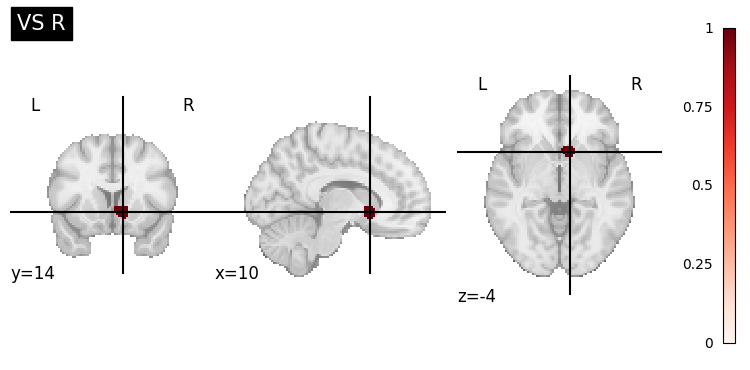

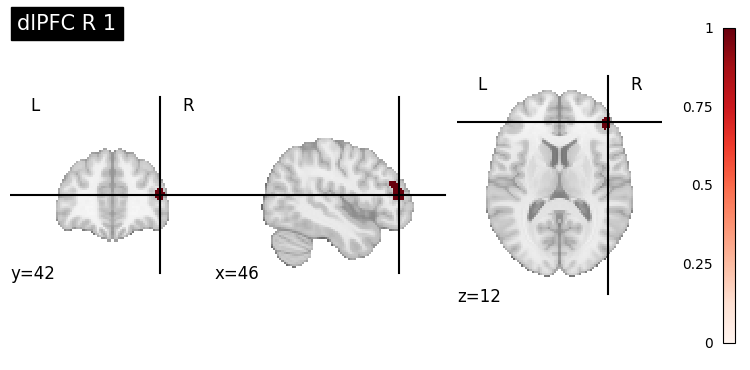

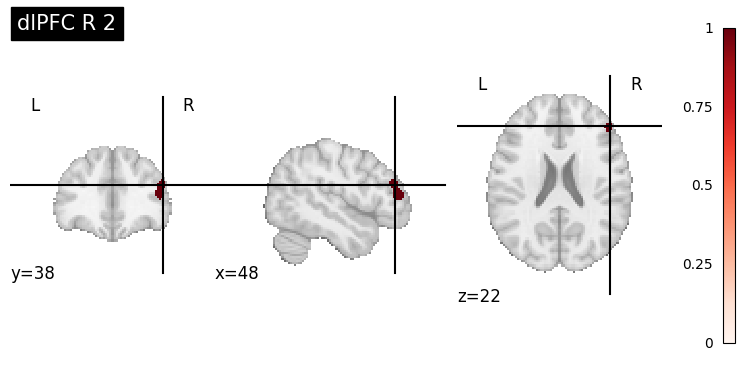

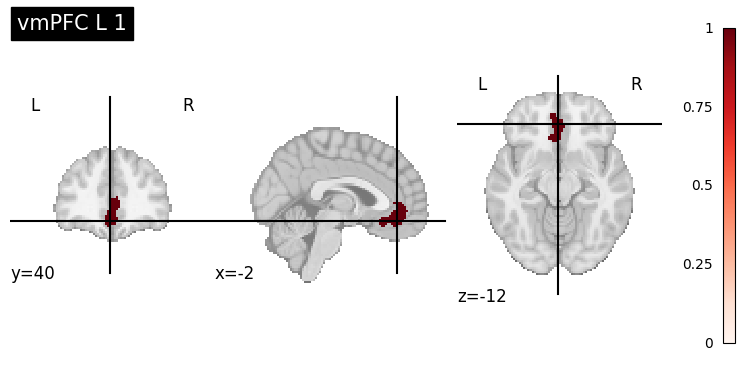

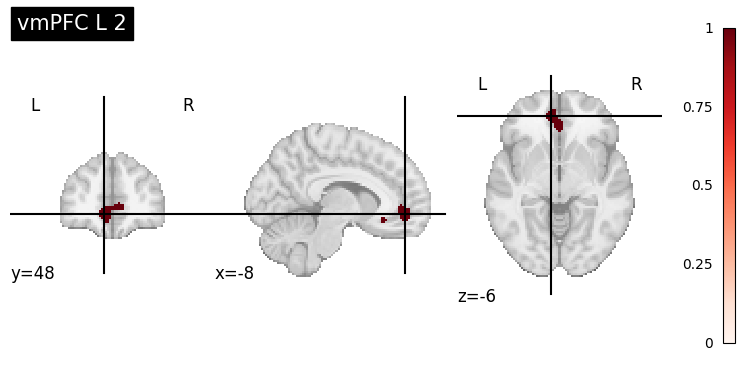

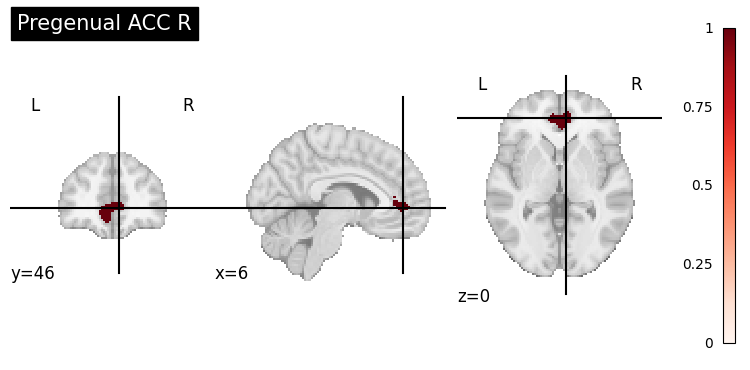

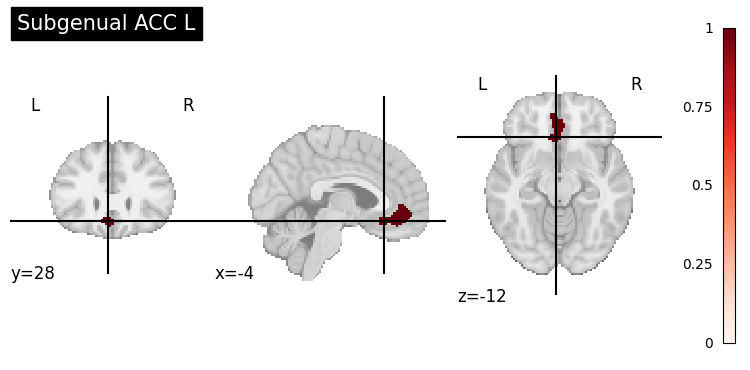

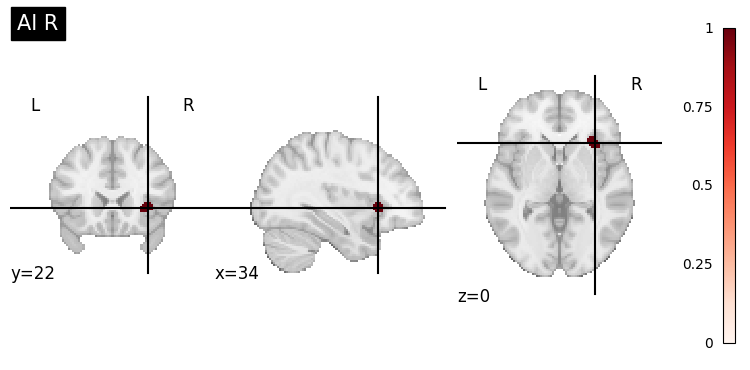

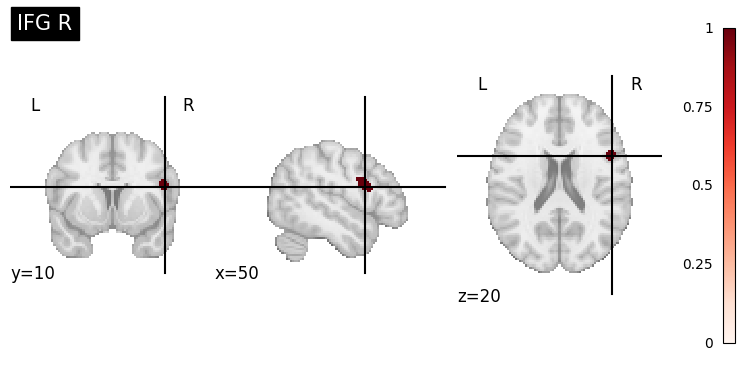

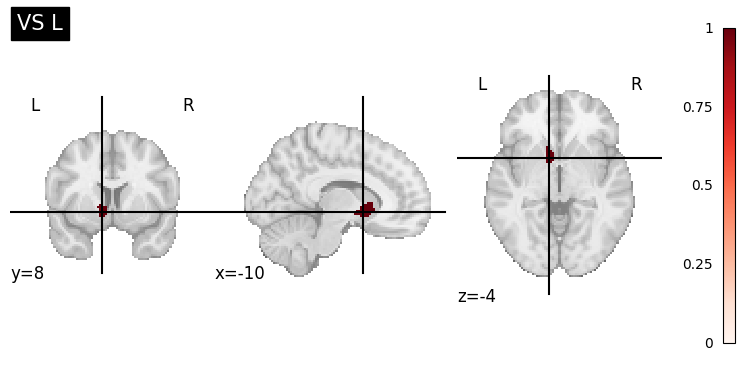

No peak coordinate found for mask 'vmPFC L merged', skipping plot.
No peak coordinate found for mask 'dlPFC R merged', skipping plot.


In [47]:
for label, mask_img in cluster_masks.items():
    # Find peak coord in clusters_table for this label
    # We assume exact match, but adjust if needed
    subset = clusters_table[clusters_table["Cluster Label"].str.strip() == label.strip()]
    if subset.empty:
        print(f"No peak coordinate found for mask '{label}', skipping plot.")
        continue

    # If multiple rows, take first (or customize)
    peak_row = subset.iloc[0]
    peak_coord = [peak_row["X"], peak_row["Y"], peak_row["Z"]]

    plot.plot_stat_map(
        mask_img,
        title=label,
        display_mode='ortho',
        cut_coords=peak_coord,
        threshold=0,
        cmap='Reds',
        draw_cross=True
    )
    plot.show()

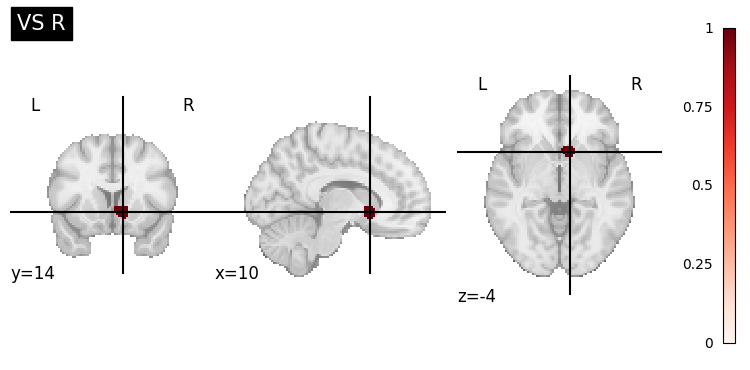

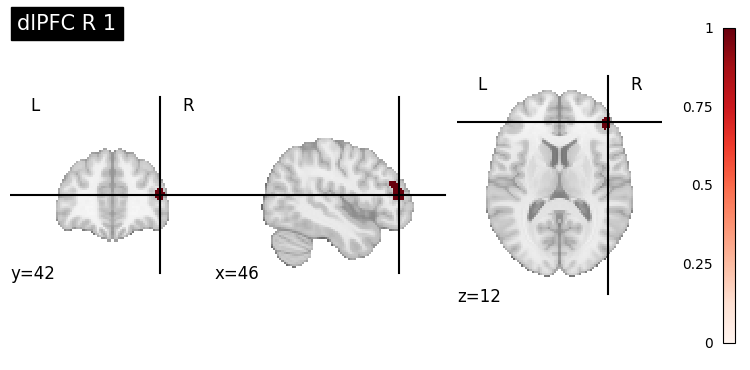

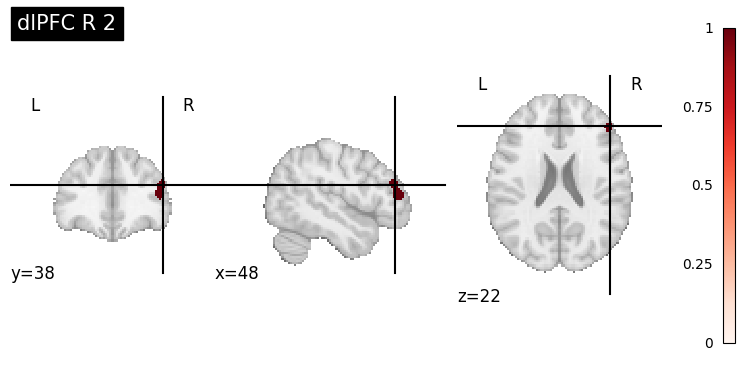

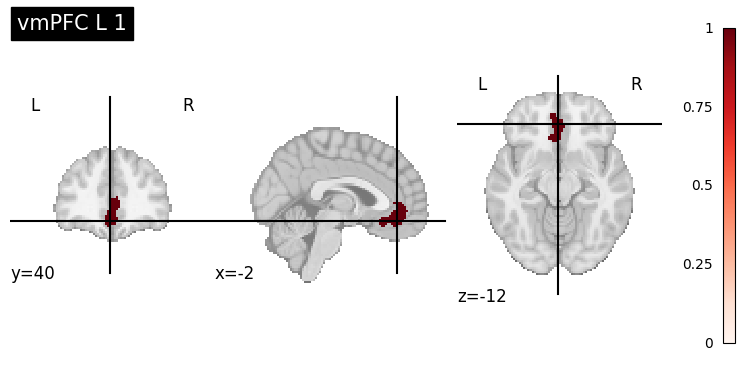

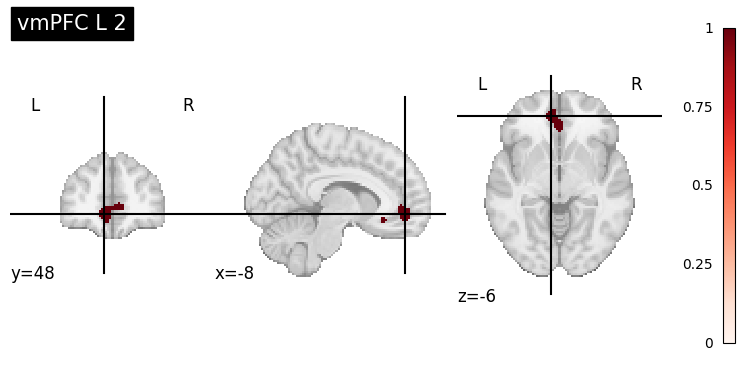

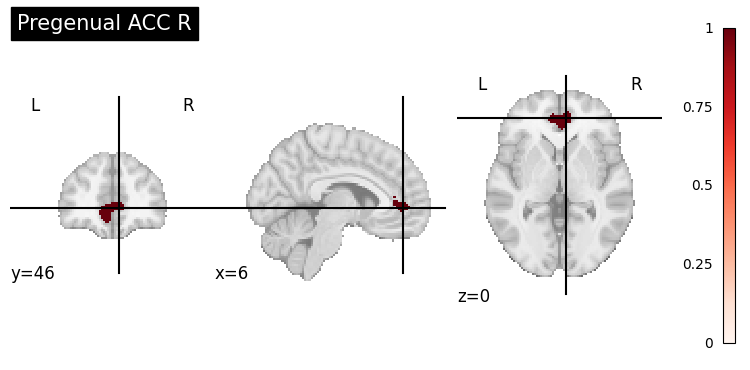

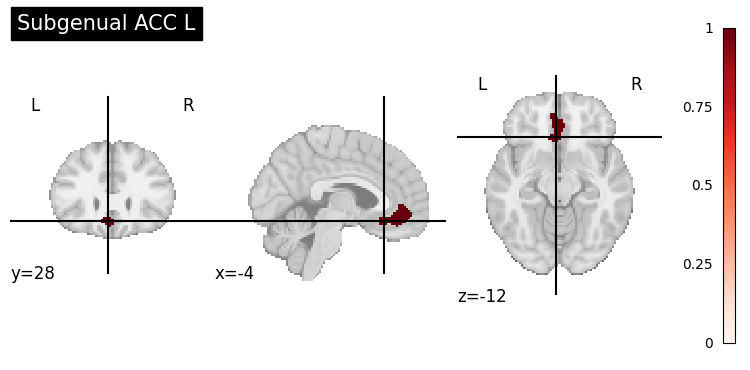

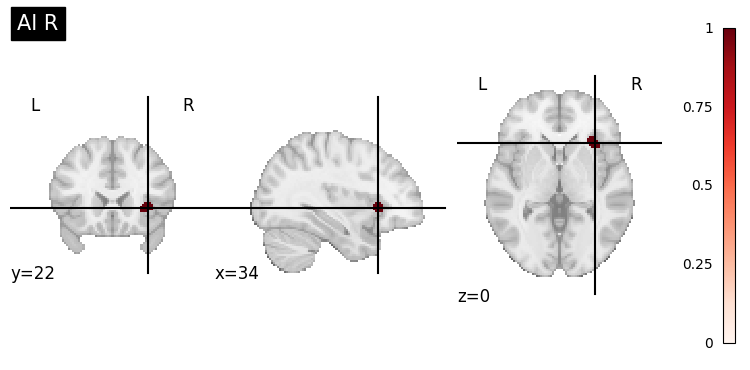

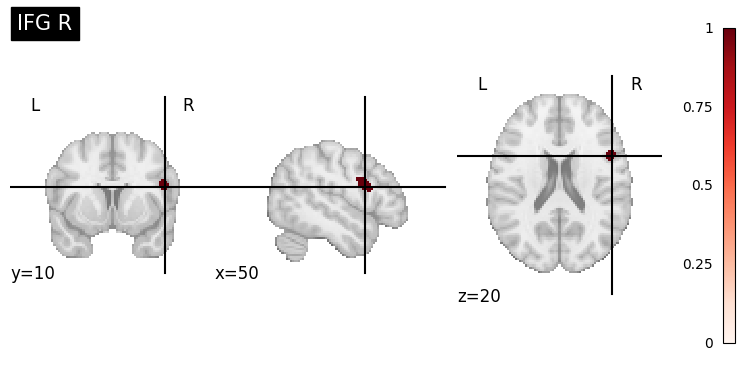

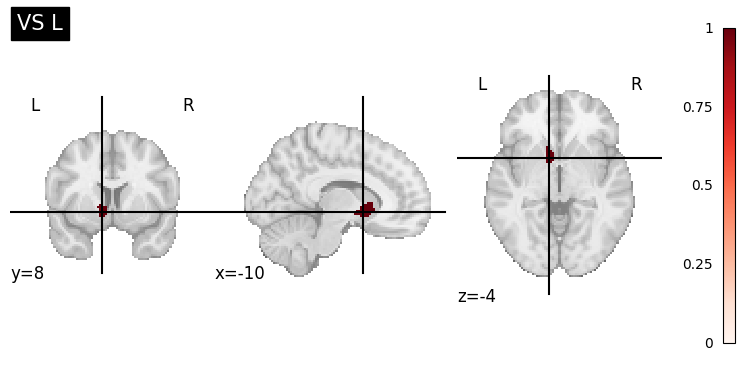

Using first voxel [32 79 32] in MNI space [-12.  46.  -6.] for mask 'vmPFC L merged'.


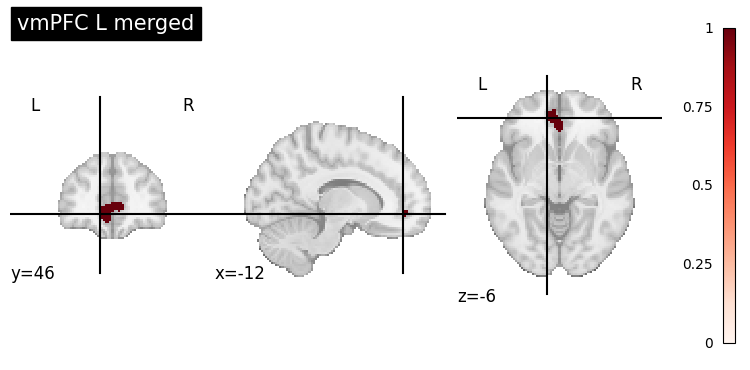

Using first voxel [58 76 42] in MNI space [40. 40. 14.] for mask 'dlPFC R merged'.


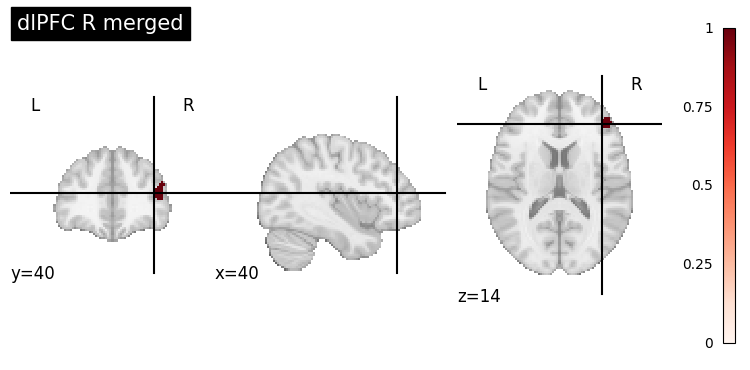

In [48]:
for label, mask_img in cluster_masks.items():
    # Try to find the peak coordinate from the original table
    subset = clusters_table[clusters_table["Cluster Label"].str.strip() == label.strip()]
    
    if not subset.empty:
        # Use original peak MNI coordinate
        peak_row = subset.iloc[0]
        cut_coord = [peak_row["X"], peak_row["Y"], peak_row["Z"]]
    else:
        # Fallback: find first voxel = 1 and convert to MNI
        data = mask_img.get_fdata()
        indices = np.argwhere(data == 1)

        if indices.size == 0:
            print(f"No voxels found in mask '{label}', skipping plot.")
            continue

        first_voxel = indices[0]
        # Convert voxel to MNI using affine
        cut_coord = nib.affines.apply_affine(mask_img.affine, first_voxel)
        print(f"Using first voxel {first_voxel} in MNI space {cut_coord} for mask '{label}'.")

    # Plot
    plot.plot_stat_map(
        mask_img,
        title=label,
        display_mode='ortho',
        cut_coords=cut_coord,
        threshold=0,
        cmap='Reds',
        draw_cross=True
    )
    plot.show()

In [49]:
# Save each mask
for label, mask_img in cluster_masks.items():
    # Clean the label to make it filename-safe
    safe_label = label.strip().replace(" ", "_")
    out_path = os.path.join(results_dir, f"cluster_{safe_label}.nii.gz")

    mask_img.to_filename(out_path)
    print(f"Saved: {out_path}")

Saved: /home/gagpat01/Documents/GutBrain/BIDS_results/cluster_VS_R.nii.gz
Saved: /home/gagpat01/Documents/GutBrain/BIDS_results/cluster_dlPFC_R_1.nii.gz
Saved: /home/gagpat01/Documents/GutBrain/BIDS_results/cluster_dlPFC_R_2.nii.gz
Saved: /home/gagpat01/Documents/GutBrain/BIDS_results/cluster_vmPFC_L_1.nii.gz
Saved: /home/gagpat01/Documents/GutBrain/BIDS_results/cluster_vmPFC_L_2.nii.gz
Saved: /home/gagpat01/Documents/GutBrain/BIDS_results/cluster_Pregenual_ACC_R.nii.gz
Saved: /home/gagpat01/Documents/GutBrain/BIDS_results/cluster_Subgenual_ACC_L.nii.gz
Saved: /home/gagpat01/Documents/GutBrain/BIDS_results/cluster_AI_R.nii.gz
Saved: /home/gagpat01/Documents/GutBrain/BIDS_results/cluster_IFG_R.nii.gz
Saved: /home/gagpat01/Documents/GutBrain/BIDS_results/cluster_VS_L.nii.gz
Saved: /home/gagpat01/Documents/GutBrain/BIDS_results/cluster_vmPFC_L_merged.nii.gz
Saved: /home/gagpat01/Documents/GutBrain/BIDS_results/cluster_dlPFC_R_merged.nii.gz
